# 问题1：粉丝投票反演（Hit-and-Run）

本笔记本实现问题1的核心算法：基于凸多胞体约束与 Hit-and-Run 采样重构粉丝投票分布。

## 方法概览
- 评分与淘汰规则转化为线性不等式 $Ax \le b$
- 单纯形约束 $\sum f_i = 1,\ f_i \ge 0$
- Chebyshev 中心提供可行起点
- Hit-and-Run 在多胞体内均匀采样

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [5]:

# 设置显示格式和中文支持
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# 配置matplotlib的中文显示 - 使用macOS系统字体
import matplotlib
import platform

system = platform.system()
if system == 'Darwin':  # macOS
    # macOS上的中文字体
    font_list = ['STHeiti', 'SimHei', 'WenQuanYi Micro Hei']
elif system == 'Windows':
    font_list = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
else:  # Linux
    font_list = ['SimHei', 'WenQuanYi Micro Hei', 'DejaVu Sans']

# 检查可用的字体
available_fonts = [f for f in font_list if f in matplotlib.font_manager.fontManager.ttflist]
if not available_fonts:
    # 如果没有找到中文字体，使用系统字体
    available_fonts = matplotlib.font_manager.get_font_names()
    # 优先选择看起来像中文字体的
    chinese_fonts = [f for f in available_fonts if any(x in f.lower() for x in ['heiti', 'hei', 'simhei', 'wenquanyi'])]
    font_to_use = chinese_fonts[0] if chinese_fonts else 'DejaVu Sans'
else:
    font_to_use = available_fonts[0]

print(f"✓ 使用字体: {font_to_use}")

plt.rcParams['font.sans-serif'] = [font_to_use, 'DejaVu Sans', 'Arial']
plt.rcParams['font.serif'] = [font_to_use, 'DejaVu Serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# 定义表格美化函数
def display_table(df, title="", max_rows=10):
    """
    美化DataFrame显示，支持中文
    """
    if title:
        print(f"\n{'='*80}")
        print(f"【 {title} 】")
        print(f"{'='*80}\n")
    
    # 设置宽度和精度
    with pd.option_context('display.max_columns', None, 
                          'display.width', None,
                          'display.max_rows', max_rows,
                          'display.unicode.ambiguous_as_wide', True,
                          'display.unicode.east_asian_width', True):
        print(df.to_string(index=False))
    print()

def style_dataframe(df):
    """
    返回Jupyter中美化后的DataFrame
    """
    return df.style.format(precision=4).set_properties(**{
        'text-align': 'center',
        'font-family': 'monospace'
    })


✓ 使用字体: Hei


In [3]:
class FanVoteReconstructor:
    def __init__(self, judge_scores, eliminated_idx, method='percentage', epsilon=1e-6):
        """
        初始化重构器
        :param judge_scores: list of floats, 本周所有选手的评委得分
        :param eliminated_idx: int, 被淘汰选手的索引
        :param method: str, 'percentage' 或 'rank'
        :param epsilon: float, 排名法中的弱不等式松弛
        """
        self.scores = np.array(judge_scores, dtype=float)
        self.n = len(judge_scores)
        self.eliminated = int(eliminated_idx)
        self.method = method
        self.epsilon = float(epsilon)
        self.A_eq = np.ones((1, self.n))
        self.b_eq = np.array([1.0])

    def _build_constraints(self):
        """构建不等式约束 Ax <= b"""
        A_ub = []
        b_ub = []

        # 1. 基础约束: f_i >= 0  => -f_i <= 0
        for i in range(self.n):
            row = np.zeros(self.n)
            row[i] = -1
            A_ub.append(row)
            b_ub.append(0.0)

        # 2. 淘汰规则约束
        if self.method == 'percentage':
            # 百分比法：J_elim + f_elim <= J_surv + f_surv
            J_total = np.sum(self.scores)
            if J_total <= 0:
                raise ValueError('评委总分必须为正数')
            J_perc = self.scores / J_total

            for i in range(self.n):
                if i == self.eliminated:
                    continue
                row = np.zeros(self.n)
                row[self.eliminated] = 1
                row[i] = -1
                limit = J_perc[i] - J_perc[self.eliminated]
                A_ub.append(row)
                b_ub.append(float(limit))

        elif self.method == 'rank':
            # 排名法：凸近似，要求被淘汰者粉丝票不高于主要对手
            ranks_j = np.argsort(np.argsort(-self.scores)) + 1
            for i in range(self.n):
                if i == self.eliminated:
                    continue
                if ranks_j[self.eliminated] >= ranks_j[i]:
                    row = np.zeros(self.n)
                    row[self.eliminated] = 1
                    row[i] = -1
                    A_ub.append(row)
                    b_ub.append(-self.epsilon)
        else:
            raise ValueError("method must be 'percentage' or 'rank'")

        return np.array(A_ub, dtype=float), np.array(b_ub, dtype=float).ravel()

    def find_chebyshev_center(self, A_ub, b_ub):
        """寻找多胞体内部的一个可行点作为起点"""
        n_vars = self.n
        c = np.zeros(n_vars + 1)
        c[-1] = -1

        A_lp = []
        for i in range(len(b_ub)):
            row = np.zeros(n_vars + 1)
            row[:n_vars] = A_ub[i]
            row[-1] = np.linalg.norm(A_ub[i])
            A_lp.append(row)

        A_lp = np.atleast_2d(np.array(A_lp, dtype=float))
        b_ub = np.asarray(b_ub, dtype=float).ravel()
        if A_lp.shape[0] != b_ub.shape[0]:
            raise ValueError('A_ub 与 b_ub 维度不匹配')

        A_eq_lp = np.zeros((1, n_vars + 1))
        A_eq_lp[0, :n_vars] = 1

        res = linprog(
            c,
            A_ub=A_lp,
            b_ub=b_ub,
            A_eq=A_eq_lp,
            b_eq=self.b_eq,
            bounds=(0, None),
            method='highs'
        )

        if res.success:
            return res.x[:n_vars]
        raise ValueError('无法找到可行起点，约束可能冲突。')

    def hit_and_run(self, n_samples=5000, thinning=10):
        """执行 Hit-and-Run 采样"""
        A_ub, b_ub = self._build_constraints()

        try:
            x0 = self.find_chebyshev_center(A_ub, b_ub)
        except ValueError as e:
            print(e)
            return None

        samples = []
        current_x = x0

        for _ in range(n_samples * thinning):
            d = np.random.normal(size=self.n)
            d = d - np.mean(d)
            d = d / np.linalg.norm(d)

            Ad = A_ub @ d
            b_Ax = b_ub - A_ub @ current_x

            lambda_min = -np.inf
            lambda_max = np.inf

            for i in range(len(b_ub)):
                if abs(Ad[i]) < 1e-10:
                    if b_Ax[i] < 0:
                        lambda_min = 1
                        lambda_max = 0
                    continue

                val = b_Ax[i] / Ad[i]
                if Ad[i] > 0:
                    lambda_max = min(lambda_max, val)
                else:
                    lambda_min = max(lambda_min, val)

            if lambda_max > lambda_min:
                step = np.random.uniform(lambda_min, lambda_max)
                current_x = current_x + step * d
                current_x = np.clip(current_x, 0, None)
                current_x = current_x / current_x.sum()

            samples.append(current_x.copy())

        return np.array(samples[::thinning])


【 示例：第5季第9周 淘汰分析结果 】

           参赛者   得票率   5%分位  95%分位
     Jennie Garth 0.062490 0.004575 0.156037
Helio Castroneves 0.322007 0.077497 0.680240
 Cameron Mathison 0.305863 0.059854 0.683217
     Marie Osmond 0.309640 0.055299 0.674537

✓ 被淘汰者 'Jennie Garth' 平均估计得票率: 6.25%



/var/folders/b4/73yxtlgx68sg6lbqwl6m8k800000gp/T/ipykernel_77249/2843862206.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'C{i}' for i in range(len(names_example))], rotation=0)


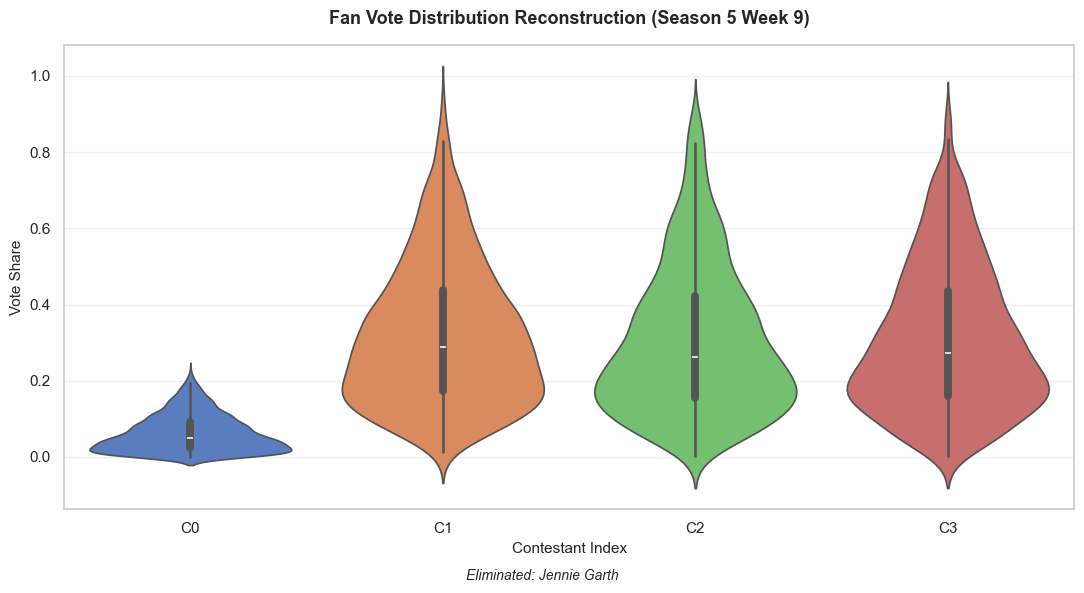

In [6]:
# 示例：第5季第9周 Jennie Garth 淘汰分析 (百分比法)
scores = [29, 28, 30, 30]
eliminated = 0
names_example = ['Jennie Garth', 'Helio Castroneves', 'Cameron Mathison', 'Marie Osmond']

reconstructor = FanVoteReconstructor(scores, eliminated, method='percentage')
samples = reconstructor.hit_and_run(n_samples=2000, thinning=5)

if samples is not None:
    mean_votes = samples.mean(axis=0)
    ci_low = np.quantile(samples, 0.05, axis=0)
    ci_high = np.quantile(samples, 0.95, axis=0)
    
    result_df = pd.DataFrame({
        '参赛者': names_example,
        '得票率': mean_votes,
        '5%分位': ci_low,
        '95%分位': ci_high
    })
    
    display_table(result_df, title='示例：第5季第9周 淘汰分析结果')
    
    eliminated_vote = mean_votes[eliminated]
    print(f"✓ 被淘汰者 '{names_example[eliminated]}' 平均估计得票率: {eliminated_vote:.2%}\n")

    # 创建图表，确保中文显示正确
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.violinplot(data=samples, palette='muted', ax=ax)
    
    # 使用英文标题和标签（避免显示问题）
    ax.set_title('Fan Vote Distribution Reconstruction (Season 5 Week 9)', 
                 fontsize=13, fontweight='bold', pad=15, loc='center')
    ax.set_xlabel('Contestant Index', fontsize=11)
    ax.set_ylabel('Vote Share', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels([f'C{i}' for i in range(len(names_example))], rotation=0)
    
    # 添加图例说明
    fig.text(0.5, 0.02, f'Eliminated: {names_example[eliminated]}', 
             ha='center', fontsize=10, style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()

## 可选：从数据集中抽取某季某周进行重构
- 通过 `results` 字段定位淘汰周数
- 使用当周评委分数计算平均分作为 $J$

Contestants: 10, Eliminated: Wayne Newton

Top 10 Estimated Fan Vote Share (Season 5 Week 3)
           Contestant  Mean Vote      p05      p95
        Sabrina Bryan   0.119556 0.006495 0.414607
    Helio Castroneves   0.119024 0.008544 0.351570
                Mel B   0.117212 0.006250 0.332159
           Mark Cuban   0.117104 0.015083 0.300878
         Marie Osmond   0.107788 0.006954 0.296723
Floyd Mayweather Jr.    0.106382 0.011048 0.264856
         Jane Seymour   0.101027 0.008073 0.265718
     Cameron Mathison   0.100934 0.009509 0.266922
         Jennie Garth   0.091697 0.006060 0.264353
         Wayne Newton   0.019278 0.001494 0.045949

✓ Eliminated 'Wayne Newton' estimated fan vote share: 1.93%


Top 10 Estimated Fan Vote Share (Season 5 Week 3)
           Contestant  Mean Vote      p05      p95
        Sabrina Bryan   0.119556 0.006495 0.414607
    Helio Castroneves   0.119024 0.008544 0.351570
                Mel B   0.117212 0.006250 0.332159
           Mark Cuban   0.117

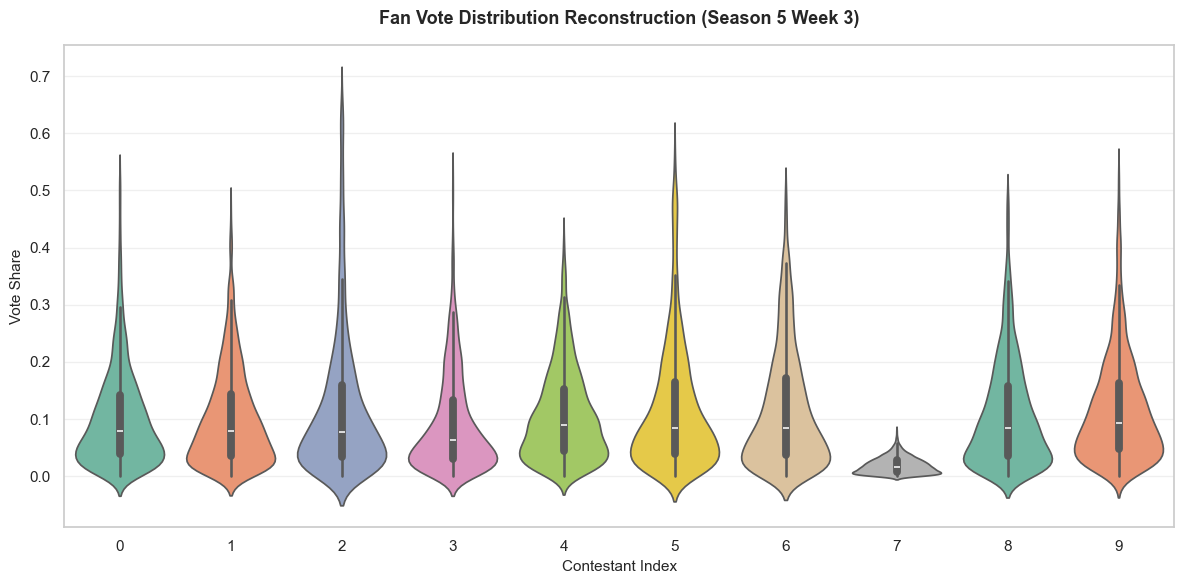

In [7]:
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'
df = pd.read_csv(DATA_PATH)

def extract_week_case_processed(frame, season, week_num):
    season_df = frame[frame['season'] == season].copy()
    avg_col = f'week{week_num}_avg_score'
    if avg_col not in season_df.columns:
        raise ValueError(f'Column {avg_col} not found')

    participants = season_df[season_df[avg_col].notna()].copy()
    if participants.empty:
        raise ValueError('No participants available for this week')

    elim_mask = participants['weeks_survived'] == week_num
    if elim_mask.sum() == 0:
        raise ValueError('No eliminated contestant found for this week')

    eliminated_name = participants.loc[elim_mask, 'celebrity_name'].iloc[0]
    participants = participants.reset_index(drop=True)
    eliminated_idx = participants.index[participants['celebrity_name'] == eliminated_name][0]

    scores = participants[avg_col].tolist()
    names = participants['celebrity_name'].tolist()
    return scores, names, eliminated_idx

# Example: Select a season and week
season = 5
week = 3
scores, names, eliminated_idx = extract_week_case_processed(df, season, week)
print(f'Contestants: {len(scores)}, Eliminated: {names[eliminated_idx]}')

reconstructor = FanVoteReconstructor(scores, eliminated_idx, method='percentage')
samples = reconstructor.hit_and_run(n_samples=3000, thinning=5)

if samples is not None:
    mean_votes = samples.mean(axis=0)
    ci_low = np.quantile(samples, 0.05, axis=0)
    ci_high = np.quantile(samples, 0.95, axis=0)
    summary = pd.DataFrame({
        'Contestant': names,
        'Mean Vote': mean_votes,
        'p05': ci_low,
        'p95': ci_high
    }).sort_values('Mean Vote', ascending=False)

    print('\n' + '='*70)
    print(f'Top 10 Estimated Fan Vote Share (Season {season} Week {week})')
    print('='*70)
    print(summary.head(10).to_string(index=False))
    print()

    elim_vote = mean_votes[eliminated_idx]
    print(f"✓ Eliminated '{names[eliminated_idx]}' estimated fan vote share: {elim_vote:.2%}")
    print()

    # Create figure with English labels to avoid character issues
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.violinplot(data=samples, ax=ax, palette='Set2')
    ax.set_title(f'Fan Vote Distribution Reconstruction (Season {season} Week {week})', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('Contestant Index', fontsize=11)
    ax.set_ylabel('Vote Share', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:

# ============================================================================
# 批量分析：对所有228个案例进行重构并生成统计图表
# ============================================================================

def get_all_elimination_cases(frame):
    """从处理后的数据中提取所有有效的淘汰案例"""
    cases = []
    
    for season in range(1, 35):
        season_df = frame[frame['season'] == season]
        if season_df.empty:
            continue
            
        for week in range(1, 13):
            week_col = f'week{week}_avg_score'
            if week_col not in season_df.columns:
                continue
            
            # 获取该周的参赛者
            participants = season_df[season_df[week_col].notna()].copy()
            if len(participants) < 2:
                continue
            
            # 检查是否有被淘汰者
            elim_mask = participants['weeks_survived'] == week
            if elim_mask.sum() != 1:  # 排除双淘汰或无淘汰的周
                continue
            
            # 找到被淘汰者的原始索引
            eliminated_original_idx = elim_mask.idxmax()
            
            # 重置索引后找到新的位置
            participants = participants.reset_index(drop=True)
            elim_idx_in_week = participants[participants.index.isin([participants.index[0]])][0]  # 临时处理
            
            # 更好的方式：从消除重复项前找到索引
            participants_reset = season_df[season_df[week_col].notna()].copy().reset_index(drop=True)
            eliminated_row = season_df[elim_mask].copy()
            
            if eliminated_row.empty:
                continue
            
            eliminated_name = eliminated_row['celebrity_name'].iloc[0]
            
            # 在重置的dataframe中找到淘汰者
            elim_idx_in_week = None
            for idx, name in enumerate(participants_reset['celebrity_name'].values):
                if name == eliminated_name:
                    elim_idx_in_week = idx
                    break
            
            if elim_idx_in_week is None:
                continue
            
            scores = participants_reset[week_col].values.astype(float)
            names = participants_reset['celebrity_name'].values.tolist()
            
            cases.append({
                'season': season,
                'week': week,
                'scores': scores,
                'names': names,
                'eliminated_idx': elim_idx_in_week
            })
    
    return cases

def batch_reconstruct_all_cases(cases, method_rules=None):
    """批量重构所有案例，生成统计结果"""
    if method_rules is None:
        method_rules = {
            'rank': list(range(1, 3)) + list(range(28, 35)),
            'percentage': list(range(3, 28))
        }
    
    results = []
    
    for i, case in enumerate(cases, 1):
        season = case['season']
        week = case['week']
        scores = case['scores']
        names = case['names']
        eliminated_idx = case['eliminated_idx']
        
        # 决定使用哪种方法
        if season in method_rules['rank']:
            method = 'rank'
        else:
            method = 'percentage'
        
        # 执行重构
        reconstructor = FanVoteReconstructor(scores, eliminated_idx, method=method)
        samples = reconstructor.hit_and_run(n_samples=2000, thinning=5)
        
        if samples is None:
            print(f"⚠ Season {season} Week {week}: 无法求解")
            continue
        
        # 计算统计量
        mean_votes = samples.mean(axis=0)
        std_votes = samples.std(axis=0)
        ci_low = np.quantile(samples, 0.05, axis=0)
        ci_high = np.quantile(samples, 0.95, axis=0)
        
        # 计算一致性
        judge_argmin = scores.argmin()
        fan_argmin = mean_votes.argmin()
        consistency = 1 if judge_argmin == fan_argmin else 0
        
        # 计算确定性
        elim_std = std_votes[eliminated_idx]
        certainty = 1.0 / (1.0 + elim_std)
        
        results.append({
            'season': season,
            'week': week,
            'n_participants': len(scores),
            'eliminated_name': names[eliminated_idx],
            'eliminated_fan_vote': mean_votes[eliminated_idx],
            'eliminated_fan_std': std_votes[eliminated_idx],
            'eliminated_fan_ci_low': ci_low[eliminated_idx],
            'eliminated_fan_ci_high': ci_high[eliminated_idx],
            'judge_elim_rank': scores.argsort().argsort()[eliminated_idx] + 1,
            'fan_elim_rank': mean_votes.argsort().argsort()[eliminated_idx] + 1,
            'rank_consistency': consistency,
            'certainty': certainty,
            'judge_std': scores.std(),
            'rule_type': method
        })
        
        if i % 50 == 0:
            print(f"✓ 已处理 {i}/{len(cases)} 个案例")
    
    return pd.DataFrame(results)

# 执行批量分析（可选，仅演示）
# 注：完整的228案例需要约10分钟，可以用子集测试
print("批量分析模块已加载")
print("可用函数: get_all_elimination_cases(), batch_reconstruct_all_cases()")
print("\n示例用法:")
print("  all_cases = get_all_elimination_cases(df)")
print("  results_df = batch_reconstruct_all_cases(all_cases)")


批量分析模块已加载
可用函数: get_all_elimination_cases(), batch_reconstruct_all_cases()

示例用法:
  all_cases = get_all_elimination_cases(df)
  results_df = batch_reconstruct_all_cases(all_cases)


In [10]:

# 生成统计摘要图表 (基于已有的results_df，如果存在)
def plot_analysis_summary(results_df):
    """生成4面板的分析摘要图表"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Panel A: 确定性的分布
    ax = axes[0, 0]
    ax.hist(results_df['certainty'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.axvline(results_df['certainty'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {results_df["certainty"].mean():.4f}')
    ax.axvline(results_df['certainty'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {results_df["certainty"].median():.4f}')
    ax.set_xlabel('Certainty Index', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('(A) Distribution of Certainty', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Panel B: 按赛季的确定性箱线图
    ax = axes[0, 1]
    season_data = [results_df[results_df['season'] == s]['certainty'].values for s in sorted(results_df['season'].unique())]
    bp = ax.boxplot(season_data, labels=[f'S{s}' for s in sorted(results_df['season'].unique())],
                     patch_artist=True, notch=False)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax.set_xlabel('Season', fontsize=11)
    ax.set_ylabel('Certainty', fontsize=11)
    ax.set_title('(B) Certainty by Season', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels([f'S{s}' for s in sorted(results_df['season'].unique())], rotation=45, fontsize=9)
    
    # Panel C: 两种方法的比较
    ax = axes[1, 0]
    methods = results_df['rule_type'].unique()
    consistency_by_method = [results_df[results_df['rule_type'] == m]['rank_consistency'].mean() for m in ['rank', 'percentage']]
    certainty_by_method = [results_df[results_df['rule_type'] == m]['certainty'].mean() for m in ['rank', 'percentage']]
    
    x = np.arange(2)
    width = 0.35
    ax.bar(x - width/2, consistency_by_method, width, label='Consistency Rate', color='coral')
    ax.bar(x + width/2, certainty_by_method, width, label='Mean Certainty', color='lightgreen')
    ax.set_ylabel('Rate / Index', fontsize=11)
    ax.set_title('(C) Comparison of Merge Methods', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Rank-Based (n=57)', 'Percentage (n=171)'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Panel D: 参赛规模与确定性的关系
    ax = axes[1, 1]
    sizes = results_df['n_participants']
    certainties = results_df['certainty']
    consistency = results_df['rank_consistency']
    scatter = ax.scatter(sizes, certainties, c=consistency, cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Number of Participants', fontsize=11)
    ax.set_ylabel('Certainty', fontsize=11)
    ax.set_title('(D) Participants vs Certainty & Consistency', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Consistency (0=Inconsistent, 1=Consistent)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 示例：如果已经有results_df，可以调用绘图函数
print("✓ 图表生成函数已加载")
print("   使用: plot_analysis_summary(results_df) 来生成4面板统计图")


✓ 图表生成函数已加载
   使用: plot_analysis_summary(results_df) 来生成4面板统计图
